In [1]:
import numpy as np
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import matplotlib.pyplot as plt
from edcs_gbm.cs_gbm import CSGbm
from edcs_gbm.utils import *
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
import optuna
from optuna import trial, create_study
from optuna.samplers import TPESampler

In [2]:
def cs_gbm_tuning_savings(trial, cost_train, X_train, y_train, n_splits=5, n_repeats=2, random_state=42, n_trials = 10):

    def cs_gbm_objective(trial, cost_train, X_train, y_train, n_splits=n_splits, n_repeats=n_repeats, random_state=random_state):

        rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
        y_prob = np.zeros(len(y_train))

        tmp_savings = []

        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 15),
            "random_state": random_state,
            "cost_alpha": 0.08,
            "cost_beta": 1
        }

        cost_alpha = 0.08
        cost_beta = 1
        epsilon = 10**-4

        model = CSGbm(**params)

        for train_index, test_index in rskf.split(X_train, y_train):

            xtr, xte = X_train.values[train_index], X_train.values[test_index]
            ytr, yte = y_train.values[train_index], y_train.values[test_index]
            ctr, cte = cost_train.values[train_index], cost_train.values[test_index]

            model.fit(xtr, ytr, ctr)

            tmp_test_prob = model.predict_proba(xte)

            tmp_savings.append(savings(cte, cost_alpha, cost_beta, yte, tmp_test_prob, epsilon))


        return np.array(tmp_savings).mean()

    sampler = TPESampler(seed=random_state)

    csgbm_study = create_study(direction="maximize", sampler=sampler)
    csgbm_study.optimize(
        lambda trial: cs_gbm_objective(
            trial,
            cost_train,
            X_train,
            y_train,
            n_splits=n_splits,
            n_repeats=n_repeats,
            random_state=random_state,
        ),
        n_trials=n_trials,
        n_jobs = -1
    )

    return csgbm_study

### Simple Train Test

In [3]:
np.random.seed(42)
X, y = make_classification(n_samples = 5000, n_features = 20, n_classes = 2, random_state = 42, weights = [0.3, 0.7])
X = pd.DataFrame(X)
y = pd.Series(y)
individual_costs = np.random.uniform(low = 1, high = 50, size = len(X))
individual_costs = pd.Series(individual_costs)
individual_costs = individual_costs/(individual_costs.max())
X_train, X_test, cost_train, cost_test, y_train, y_test = train_test_split(X, individual_costs, y, stratify = y, test_size = 0.25)

In [4]:
cost_alpha = 0.08
cost_beta = 1
random_state = 42
n_estimators = 100
learning_rate = 0.3
max_depth = 6
min_samples_leaf = 3

cs_gbm = CSGbm(n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    learning_rate=learning_rate,
    cost_alpha=cost_alpha,
    cost_beta=cost_beta,
    random_state=random_state)

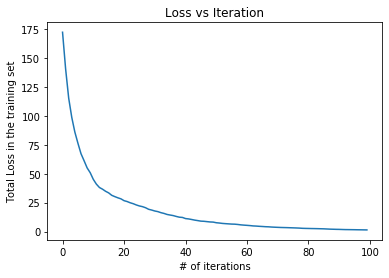

In [5]:
cs_gbm.fit(X_train.values, y_train.values, cost_train.values)
pred = cs_gbm.predict_proba(X_test)
plt.plot(cs_gbm.iteration_loss)
plt.xlabel("# of iterations")
plt.ylabel("Total Loss in the training set")
plt.title("Loss vs Iteration")
plt.show()

In [6]:
y_prob = cs_gbm.predict_proba(X_test)
y_pred = cs_gbm.predict(X_test)

In [7]:
print("train savings: " + str(np.round(savings(cost_train, cost_alpha, cost_beta, y_train, cs_gbm.predict_proba(X_train)),3)))
print("test savings: " + str(np.round(savings(cost_test, cost_alpha, cost_beta, y_test, y_prob),3)))

train savings: 0.999
test savings: 0.759


### Tuning by savings with Optuna